In [272]:
import pandas as pd
import json
from datetime import datetime
import numpy as np
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
from sklearn.metrics import *
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = []
with open("../data/yelp_data/yelp_academic_dataset_business.json", "r", encoding = "UTF-8") as f:
    for line in f:
        data.append(json.loads(line))

df = json_normalize(data)

In [32]:
df.drop(['attributes.AcceptsInsurance', 'attributes.AgesAllowed','attributes.Alcohol', 'attributes.Ambience', 'attributes.BYOB', 
         'attributes.BYOBCorkage', 'attributes.BestNights', 'attributes.BikeParking','attributes.BusinessAcceptsBitcoin',
        'attributes.BusinessAcceptsCreditCards', 'attributes.BusinessParking','attributes.ByAppointmentOnly', 
         'attributes.Caters','attributes.CoatCheck', 'attributes.Corkage','attributes.DietaryRestrictions', 
         'attributes.DogsAllowed','attributes.DriveThru', 'attributes.GoodForDancing','attributes.GoodForKids', 
         'attributes.GoodForMeal','attributes.HairSpecializesIn', 'attributes.HappyHour','attributes.HasTV',
         'attributes.Music', 'attributes.NoiseLevel','attributes.Open24Hours', 'attributes.OutdoorSeating', 
         'attributes.RestaurantsAttire', 'attributes.RestaurantsCounterService','attributes.RestaurantsDelivery', 
         'attributes.RestaurantsGoodForGroups', 'attributes.RestaurantsPriceRange2', 'attributes.RestaurantsReservations',
         'attributes.RestaurantsTableService', 'attributes.RestaurantsTakeOut', 'attributes.Smoking',
         'attributes.WheelchairAccessible','attributes.WiFi','hours.Friday',
         'hours.Monday', 'hours.Saturday', 'hours.Sunday', 'hours.Thursday','hours.Tuesday', 'hours.Wednesday', 
         'is_open'], inplace = True, axis = 1)

KeyError: "['attributes.AcceptsInsurance' 'attributes.AgesAllowed'\n 'attributes.Alcohol' 'attributes.Ambience' 'attributes.BYOB'\n 'attributes.BYOBCorkage' 'attributes.BestNights' 'attributes.BikeParking'\n 'attributes.BusinessAcceptsBitcoin'\n 'attributes.BusinessAcceptsCreditCards' 'attributes.BusinessParking'\n 'attributes.ByAppointmentOnly' 'attributes.Caters' 'attributes.CoatCheck'\n 'attributes.Corkage' 'attributes.DietaryRestrictions'\n 'attributes.DogsAllowed' 'attributes.DriveThru'\n 'attributes.GoodForDancing' 'attributes.GoodForKids'\n 'attributes.GoodForMeal' 'attributes.HairSpecializesIn'\n 'attributes.HappyHour' 'attributes.HasTV' 'attributes.Music'\n 'attributes.NoiseLevel' 'attributes.Open24Hours'\n 'attributes.OutdoorSeating' 'attributes.RestaurantsAttire'\n 'attributes.RestaurantsCounterService' 'attributes.RestaurantsDelivery'\n 'attributes.RestaurantsGoodForGroups' 'attributes.RestaurantsPriceRange2'\n 'attributes.RestaurantsReservations' 'attributes.RestaurantsTableService'\n 'attributes.RestaurantsTakeOut' 'attributes.Smoking'\n 'attributes.WheelchairAccessible' 'attributes.WiFi' 'hours.Friday'\n 'hours.Monday' 'hours.Saturday' 'hours.Sunday' 'hours.Thursday'\n 'hours.Tuesday' 'hours.Wednesday' 'is_open'] not found in axis"

In [4]:
lv_zip = [89044, 89054, 89101, 89102, 89103, 89104, 89106, 89107,
          89108, 89109, 89110, 89113, 89115, 89117, 89118, 89119, 89120, 
          89121, 89122, 89123, 89124, 89128, 89129, 89130, 89131, 89134, 
          89135, 89138, 89139, 89141, 89142, 89143, 89144, 89145, 89146, 89147, 
          89148, 89149, 89156, 89158, 89161, 89165, 89166, 89169, 89178, 89179, 89183, 89199]
lv_zip = [str(i) for i in lv_zip]
lv = df[df.postal_code.isin(lv_zip)]

In [5]:
lv_rest = pd.read_csv('../data/vegas_data.csv')
lv_rest.columns = [str.lower(i) for i in lv_rest.columns]

In [6]:
lv_rest.replace(regex = r'(?<=\d{5})-\d+', value = '', inplace = True)
lv_rest = lv_rest.dropna(subset = ['zip', 'address','restaurant name'])
lv_rest.loc[:,'address'] = lv_rest.apply(lambda row: str.lower(str(row['address'])).replace(' ', ''), axis = 1)
lv_rest.loc[:,'restaurant name']= lv_rest.apply(lambda row: str.lower(row['restaurant name']).replace(' ', ''), axis = 1)
lv.loc[:,'address'] = lv.apply(lambda row: str.lower(str(row['address'])).replace(' ', ''), axis = 1)
lv.loc[:,'name'] = lv.apply(lambda row: str.lower(row['name']).replace(' ', ''), axis = 1)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [40]:
merged = lv_rest.merge(lv, left_on = ['address','restaurant name'] , right_on =['address','name'], how = 'left')

In [41]:
merged = merged[merged['name'].notnull()]
merged.drop(['attributes','hours'],inplace=True,axis=1)
merged.to_csv('vegas_yelp_business.csv', index = False)

In [11]:
rev = []
with open("../data/yelp_data/yelp_academic_dataset_review.json", "r", encoding = "UTF-8") as f:
    for line in f:
        rev.append(json.loads(line))

yelp_reviews = json_normalize(rev)

In [23]:
bus_id = merged.business_id.unique()
yelp_reviews = yelp_reviews[yelp_reviews.business_id.isin(bus_id)]

In [44]:
yelp_reviews.to_csv('vegas_yelp_reviews.csv', index = False)

In [205]:
review_data = pd.read_csv('vegas_yelp_reviews.csv')
business_data = pd.read_csv('vegas_yelp_business.csv')

business_data['inspection date'] = pd.to_datetime(business_data['inspection date'].apply(lambda x:str(x).split()[0]), 
                                                format='%m/%d/%Y')
business_data['inspection date'] = business_data['inspection date'].apply(lambda x:datetime(x.year,x.month,1))
review_data['date'] = pd.to_datetime(review_data['date'],format='%Y-%m-%d')
review_data['date'] = review_data['date'].apply(lambda x:datetime(x.year,x.month,1))
new_merged = business_data.merge(review_data, left_on = ['business_id','inspection date'] , right_on =['business_id','date'], how = 'left')
new_merged = new_merged[new_merged['inspection grade'].isin(['A', 'B', 'C'])]
new_merged = new_merged.dropna()

def get_max_rows(df, gp, max_feat):
    B_maxes = df.groupby(gp)[max_feat].transform(max)
    return df[df[max_feat] == B_maxes] 

latest = get_max_rows(new_merged, ['business_id', 'inspection date'], 'inspection time')
final = get_max_rows(latest, ['business_id', 'inspection date'], 'review_id')

print(latest.shape)
print(final.shape)

(1426, 42)
(273, 42)


In [207]:
#Code to extract aggregated ratings from all reviews. Takes a while to execute. ~3 mins
grouped = latest.groupby(['business_id', 'inspection date'])['stars_y'].mean()
final['avg_stars'] = 0
for i in final.iterrows():
    bus_id = i[1]['business_id']
    ins_date = i[1]['inspection date']
    mean=grouped.loc[(bus_id,ins_date)]
    final.loc[i[0],'avg_stars']=mean
    
#Code to extract aggregated useful ratings from all reviews. Takes a while to execute. ~3 mins
grouped = latest.groupby(['business_id', 'inspection date'])['useful'].mean()
final['avg_useful'] = 0
for i in final.iterrows():
    bus_id = i[1]['business_id']
    ins_date = i[1]['inspection date']
    mean=grouped.loc[(bus_id,ins_date)]
    final.loc[i[0],'avg_useful']=mean
final['avg_useful']

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [243]:
drop_list = ['serial number', 'permit number', 'restaurant name', 'location name',
       'address', 'city_x', 'state_x','inspection date',
       'current demerits', 'current grade', 'date current',
       'inspection time', 'employee id', 
       'inspection result', 'violations', 'record updated', 'location 1',
       'business_id', 'city_y',  'name',
       'neighborhood', 'review_id','postal_code',  'state_y','date', 'inspection demerits', 
       'user_id']
#'review_count','zip','cool', 'funny','useful','stars_y'
additional_drop_list = ['permit status','text','categories','latitude', 'longitude','avg_useful','avg_stars']
first_model = final.drop(drop_list+additional_drop_list, axis = 1)
first_model['inspection type'] = pd.factorize(first_model['inspection type'])[0]
first_model['category name'] = pd.factorize(first_model['category name'])[0]
first_model['inspection grade'] = pd.factorize(first_model['inspection grade'])[0]
first_model.columns

Index(['category name', 'zip', 'inspection type', 'inspection grade',
       'review_count', 'stars_x', 'cool', 'funny', 'stars_y', 'useful'],
      dtype='object')

0    164
1     23
2     17
Name: inspection grade, dtype: int64
0    60
1     6
2     3
Name: inspection grade, dtype: int64
0.7391304347826086
[[50  5  2]
 [ 4  1  1]
 [ 6  0  0]]


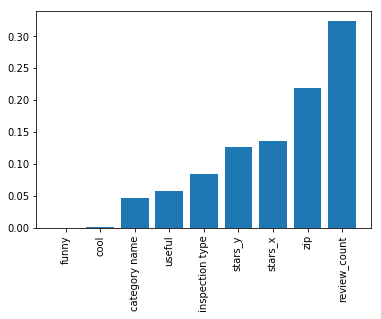

,feature_importance
funny,0.000000
cool,0.002219
category name,0.047702
useful,0.057970
inspection type,0.084473
stars_y,0.126902
stars_x,0.136647
zip,0.219905
review_count,0.324180


In [299]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

X = first_model
X=X.drop(['inspection grade'],axis=1)

Y = first_model['inspection grade']
x_train, x_test, y_train, y_test = train_test_split(first_model, first_model['inspection grade'], test_size=0.25, random_state=42)

print(x_train['inspection grade'].value_counts())
print(y_test.value_counts())

max_cnt = x_train['inspection grade'].value_counts()[0]
major_1 = x_train[x_train['inspection grade'] == 0]
minority_1= x_train[x_train['inspection grade'] == 1]
minority_2 = x_train[x_train['inspection grade'] == 2]

min1_up = resample(minority_1, replace=True, n_samples=max_cnt, random_state=123)
min2_up = resample(minority_2, replace=True, n_samples=max_cnt, random_state=124)
x_train = pd.concat([major_1, min1_up, min2_up])
y_train = x_train['inspection grade']
x_train = x_train.drop(['inspection grade'],axis=1)
x_test = x_test.drop(['inspection grade'],axis=1)

# clf = LogisticRegression()
clf = DecisionTreeClassifier(criterion = 'entropy')
clf = clf.fit(x_train, y_train)
preds = clf.predict(x_test)
print(accuracy_score(preds,y_test))
print(confusion_matrix(preds,y_test))

feat_dict = dict(zip(x_train.columns,clf.feature_importances_))
features = pd.DataFrame(pd.Series(feat_dict),columns=['feature_importance'])
sortd= features.sort_values(by=['feature_importance'])

plt.bar(range(len(sortd)), sortd['feature_importance'], align='center')
plt.xticks(range(len(sortd)), sortd.index,rotation = 'vertical')

plt.show()
sortd

In [302]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

kfolds = KFold(n_splits = 4)

steps = [('scaler', StandardScaler()),
         ('dt', DecisionTreeClassifier())]

pipeline = Pipeline(steps)

parameters_scaler = dict(dt__criterion = ['gini','entropy'],
                  dt__splitter = ['best', 'random'],
                        dt__min_samples_leaf = [1,5,10,20],
                        dt__class_weight = ['balanced',None])

dt_grid_search_scaler = GridSearchCV(pipeline, param_grid = parameters_scaler, cv = kfolds, scoring = 'accuracy')

dt_grid_search_scaler.fit(X, Y)
print(dt_grid_search_scaler.best_score_)

0.8205128205128205


In [303]:
dt_grid_search_scaler.best_estimator_.steps[-1][1]

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='random')